In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (
    AnchoredOffsetbox, AuxTransformBox, DrawingArea, TextArea, VPacker)
import math
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd

In [2]:
def segment_circle(num_segments):
    """Split a circle into num_segments segments
    
    Args:
        num_segments (int): number of segments to split the circle into
        
    Returns:
        a numpy array of size [num_segments x 3] containing the (x, y)
        co-ordinates of the segment and it's angle in radians
    """
    # calculate the size in radians of each segment of the circle
    segment_rad = 2*np.pi/num_segments
    # create a list of all the radians for each segment
    segment_rads = segment_rad*np.arange(num_segments)
    # calculate the X,Y co-ordinates for each segment
    coordX = np.cos(segment_rads)
    coordY = np.sin(segment_rads)
    # return the concatenation of the 3 arrays along the second axis
    return np.c_[coordX, coordY, segment_rads]

In [3]:
r = 7.0

# months - these go backwards and start at March
months = ["Mar", "Feb", "Jan", "Dec", "Nov", "Oct", "Sep", "Aug", "Jul", "Jun", "May", "Apr"]
# month index lookup table
month_idx = [2, 1, 0, 11, 10, 9, 8, 7, 6, 5, 4, 3]
radius = r + 0.4
month_points = segment_circle(len(months))

## Load Climate Data
Load the climate data and look at the first few entries.

In [4]:
# download file from: 
# https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/diagnostics/HadCRUT.5.0.1.0.analysis.summary_series.global.monthly.csv
# and store locally
df = pd.read_csv('D:/Data/ClimateData/HadCRUT.5.0.1.0.analysis.summary_series.global.monthly.csv')
df.head()

,Time,Anomaly (deg C),Lower confidence limit (2.5%),Upper confidence limit (97.5%)
0,1850-01,-0.674564,-0.981772,-0.367357
1,1850-02,-0.333416,-0.700901,0.034069
2,1850-03,-0.591323,-0.933919,-0.248726
3,1850-04,-0.588721,-0.898259,-0.279183
4,1850-05,-0.508185,-0.761214,-0.255157


Convert the **Time** column to a datetime.

In [5]:
df['Time'] = pd.to_datetime(df['Time'])

Let's have a look at the data.

In [6]:
df.describe()

,Anomaly (deg C),Lower confidence limit (2.5%),Upper confidence limit (97.5%)
count,2064.000000,2064.000000,2064.000000
mean,-0.084091,-0.225707,0.057526
std,0.382165,0.439225,0.335081
min,-1.044895,-1.223405,-0.866385
25%,-0.350871,-0.549884,-0.171626
50%,-0.162332,-0.314349,-0.004510
75%,0.103979,0.001595,0.220972
max,1.223588,1.183902,1.263275


This tells us that the minimum value is -1.04 and the maximimum is 1.23. Let's plot a range of values from -1.5 to 2.1. If we adjust all the values by +1.5 this will make sure that our negative values aren't directly at the centre of the circle. We want to move it slightly away. Adding 1.5 means our new scale goes from 0 to 3.6.

In [7]:
r_factor = r / 3.6  # original scale goes from -1.5 to 2.1. adjusted scale goes from 0 to 3.6
x_orig = df['Anomaly (deg C)'].to_numpy() + 1.5  # adjust all the values by +1.5
x_vals = []
y_vals = []
for i in range(0, len(x_orig)):
    r_pos = x_orig[i] * r_factor
    x_unit_r, y_unit_r = month_points[month_idx[i % 12], :2]
    x_r, y_r = (r_pos*x_unit_r, r_pos*y_unit_r)
    x_vals.append(x_r)
    y_vals.append(y_r)

In [8]:
segments = [np.column_stack([x, y]) for x, y in zip(x_vals, y_vals)]

In [9]:
pts = np.array([x_vals, y_vals]).T.reshape(-1, 1, 2)
segments = np.concatenate([pts[:-1], pts[1:]], axis=1)

Create a LineCollection of all our points and use the jet colour map to colour them. We need to normalize the colour map values to make sure they are in our shifted range of 0 to 3.6.

In [10]:
lc = LineCollection(segments, cmap=plt.get_cmap('jet'), norm=plt.Normalize(0, 3.6))
lc.set_array(np.asarray(x_orig))

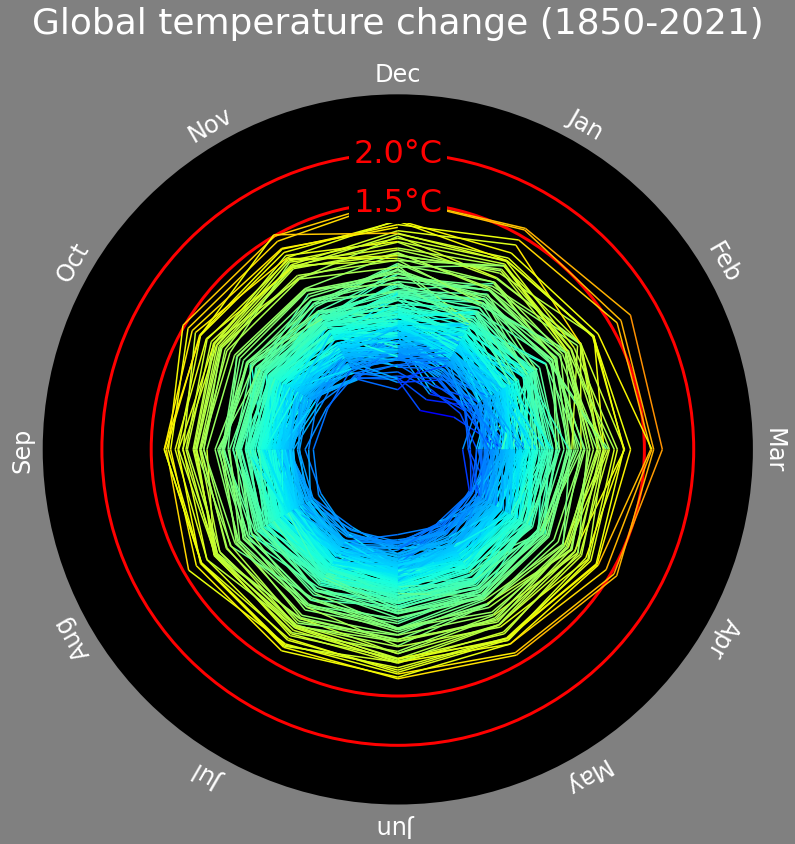

In [11]:
fig, ax = plt.subplots(figsize=(14, 14))
fig.patch.set_facecolor('grey')
ax.axis('equal')

ax.set(xlim=(-10, 10), ylim=(-10, 10))

circle = plt.Circle((0, 0), r, fc='#000000')
ax.add_patch(circle)

circle_2 = plt.Circle((0, 0), r_factor * 2.5, ec='red', fc=None, fill=False, lw=3.0)
ax.add_patch(circle_2)
circle_1_5 = plt.Circle((0, 0), r_factor * 3.0, ec='red', fc=None, fill=False, lw=3.0)
ax.add_patch(circle_1_5)

props_months = {'ha': 'center', 'va': 'center', 'fontsize': 24, 'color': 'white'}
props_year = {'ha': 'center', 'va': 'center', 'fontsize': 36, 'color': 'white'}
props_temp = {'ha': 'center', 'va': 'center', 'fontsize': 32, 'color': 'red'}
ax.text(0, r_factor * 2.5, '1.5°C', props_temp, bbox=dict(facecolor='black'))
ax.text(0, r_factor * 3.0, '2.0°C', props_temp, bbox=dict(facecolor='black'))
ax.text(0, r + 1.4, 'Global temperature change (1850-2021)', props_year)

# draw the month legends around the rim of the circle
for j in range(0, len(months)):
    x_unit_r, y_unit_r, angle = month_points[j]
    x_radius, y_radius = (radius * x_unit_r, radius * y_unit_r)
    angle = angle - 0.5 * np.pi
    ax.text(x_radius, y_radius, months[j], props_months, rotation=np.rad2deg(angle), )

# add all the lines with their colours    
plt.gca().add_collection(lc)
# rescale everything so it fits in the space
ax.autoscale()
# turn off the graph axis
ax.axis("off")
# show the graph
plt.show()

In [12]:
fig.savefig(os.path.join('images', 'plotcircles.png'))